# Blood Glucose Control - EDA

**Name:** Sean Shin



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [1]:
# Necessary imports
import pandas as pd
import os

# Path to where the CSV files are stored
data = '../data/'

# Initialize a list to store the DataFrames
dfs = []

# Looping each file incase new data file is added
for file in os.listdir(data):
    # Making sure we only look at .csv files
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data, file))

        #Extract the patient identifier 
        id = file.split('_')[1].split('.')[0]

        #Add a new column
        df['id'] = id

        #Add
        dfs.append(df)

# Concatenate all the DataFrames into a singular DataFrame
combination = pd.concat(dfs, ignore_index=True)
combination.head()








,date,sender_id,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend,id
0,2024-05-01 00:00:27.029000-05:00,NaN,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
1,2024-05-01 00:05:27.183000-05:00,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
2,2024-05-01 00:10:26.949000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
3,2024-05-01 00:15:27.180000-05:00,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
4,2024-05-01 00:20:27.021000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

### **Visualization 1:**

It's commmon for PWD to monitor their carbs intake and generally avoid high glycemic index foods. However, many forget the metric glycemic load which takes both of these factors into account through calculating the multiple of the grams and the glycemic index of the food. Therefore, we can use the trends of the glucose spike along with their respective glycemic loads to see if there are strong correlation with increasing spikes with the increase in glycemic load. 

**Hypotheses:**

Increase in __Glycemic Load__ will result in an increase in __Peak Blood Glucose__

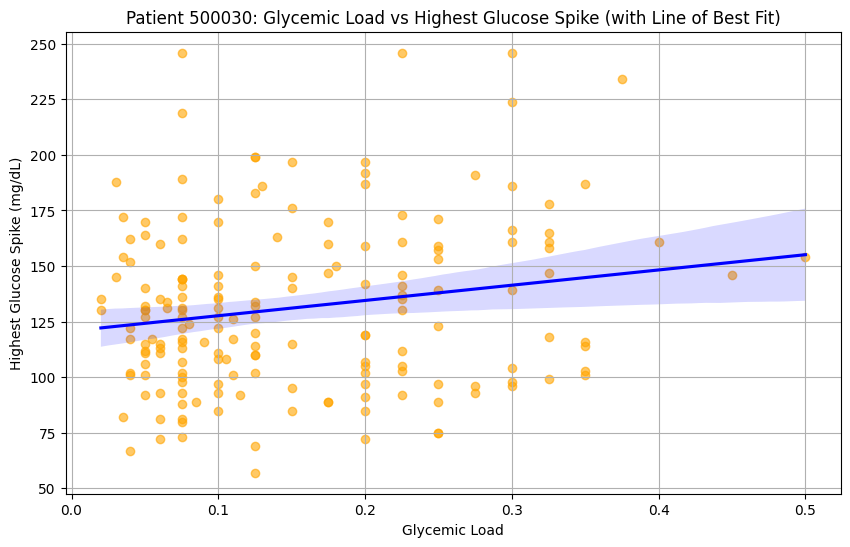

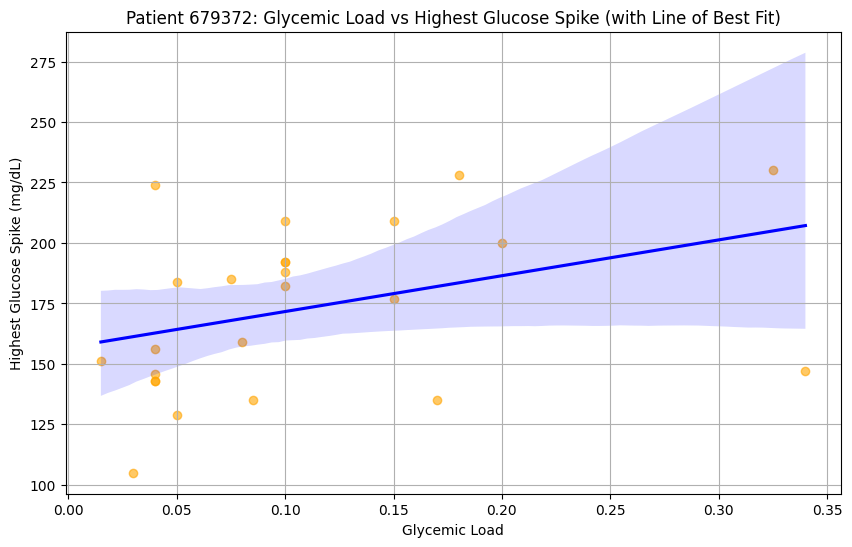

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re 


def analyze_glycemic_load_vs_spike(filename):
    """
    To analyze glycemic load and the highest glucose spike within 2 hours. 
    Displays a scatter plot of glycemic load vs highest glucose spike.
    
    Params:
        filename (str): Path to the csv file 
    Returns:
        None
    """
    # Load the CSV file
    df = pd.read_csv(filename)

    # Ensure the date column is in datetime format
    df['date'] = df['date'].str.replace(r'\.\d{6}', '', regex=True)
    df['date'] = df['date'].str.replace(r'[-+]\d{2}:\d{2}', '', regex=True)
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='raise')

    # Filter out rows with missing values in critical columns: 'bgl'
    df = df.dropna(subset=['bgl'])

    # Find Patient Number
    basename = os.path.basename(filename)  
    match = re.search(r'(\d+)', basename)
    if match:
        patient_number = match.group(1)
    else:
        patient_number = 'Unknown'

    # Initialize the lists to store the glycemic load and the highest glucose spike
    glycemic_loads = []
    highest_spikes = []

    # Loop through the dataset to track all food intakes and BGL spikes
    for i, row in df.iterrows():
        # Track any meal in take with error checks
        if row['food_g'] > 0 and row['food_glycemic_index'] > 0 and row['msg_type'] == 'ANNOUNCE_MEAL':
            carbs = row['food_g']
            glycemic_index = row['food_glycemic_index']

            # Calculate the Glycemic Load 
            glycemic_load = (carbs * glycemic_index) / 100
                        
            # Check for the highest BGL spike after the meal intake
            highest_bgl = None
            meal_time = row['date']
            # 2 hour window after meal
            two_hours_later = meal_time + pd.Timedelta(hours=2) 
            
            # Look forward in the dataset to check if any snacks exist (if found skip as it would make spike data inaccurate)
            snack_found = False
            for j in range(i + 1, len(df)):  
                next_row = df.iloc[j]
                
                # Break if the row is beyond the 2-hour window
                if next_row['date'] > two_hours_later:
                    break

                # If a snack is found skip the meal
                if next_row['msg_type'] == 'INTERVENTION_SNACK':
                    snack_found = True
                    break

                if highest_bgl is None or next_row['bgl'] > highest_bgl:
                    highest_bgl = next_row['bgl']

            # If a snack is found skip the meal
            if snack_found:
                continue

            # If a spike was found append it to the meal
            if highest_bgl is not None:
                glycemic_loads.append(glycemic_load)
                highest_spikes.append(highest_bgl)

    # Ensure both lists are the same size
    min_length = min(len(glycemic_loads), len(highest_spikes))
    glycemic_loads = glycemic_loads[:min_length]
    highest_spikes = highest_spikes[:min_length]

    # Check if there is data to plot
    if len(glycemic_loads) > 0 and len(highest_spikes) > 0:
        #  Scatter plot with Line of Best Fit
        plt.figure(figsize=(10, 6))
        sns.regplot(x=glycemic_loads, y=highest_spikes, scatter_kws={'color':'orange', 'alpha':0.6}, line_kws={'color':'blue'})
        plt.title(f'Patient {patient_number}: Glycemic Load vs Highest Glucose Spike (with Line of Best Fit)')
        plt.xlabel('Glycemic Load')
        plt.ylabel('Highest Glucose Spike (mg/dL)')
        plt.grid(True)
        plt.show()
    else:
        print(f"No data available to plot for {filename}.")

# Call the function for both files
analyze_glycemic_load_vs_spike(r'..\data\gluroo_500030.csv')
analyze_glycemic_load_vs_spike(r'..\data\gluroo_679372.csv')

**Conclusions from Visualization 1:**

The data from both patients have shown/proven that the increase in __Glycemic Load__ resulted in a increase in __Peak Blood Glucose__.

### **Visualization 2:**
In order to observe how well each individual has control over their blood sugar levels we must create a visualization of their blood glucose levels that shows relevant points within an individual's day of eating. The significant aspects of one's glucose level timeline are:

- When the patient eats their Meal
- When the patient eats their Snack
- When the patient injects their Insuline (Along with the dosage)
- When the user enters the range of hypoglycemia and hyperglycemia. 

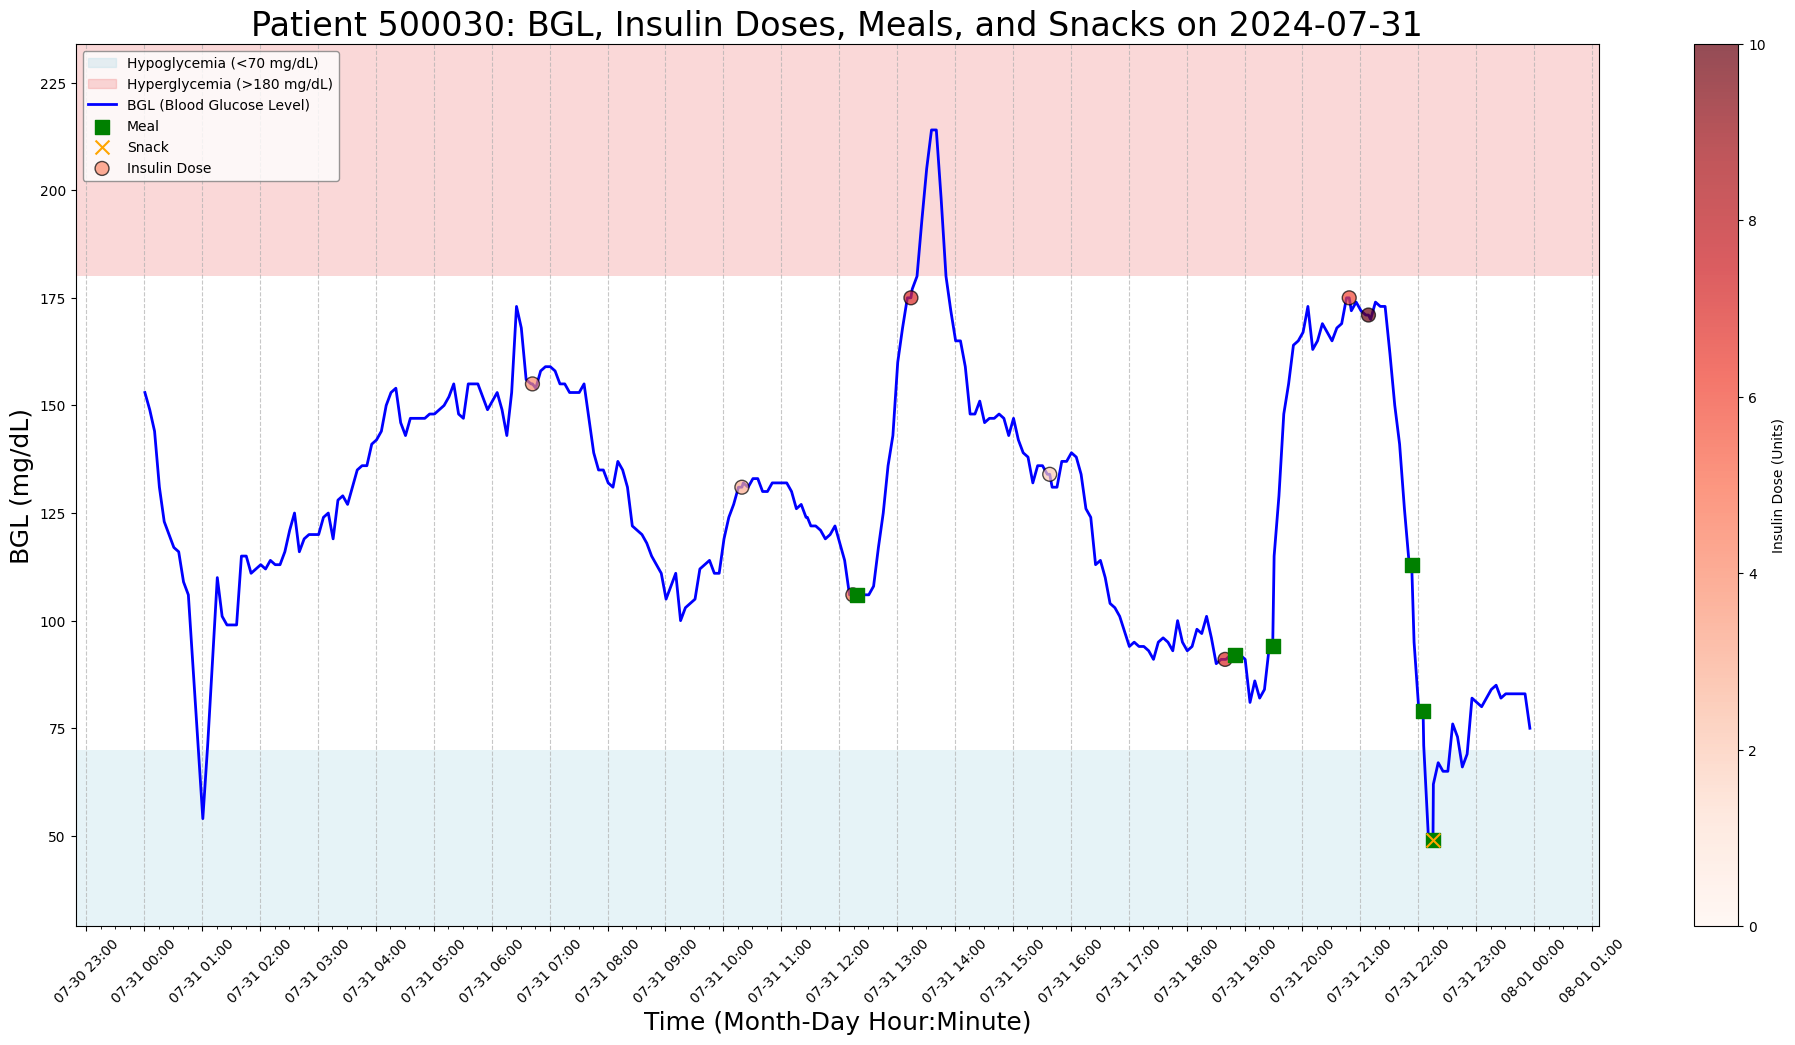

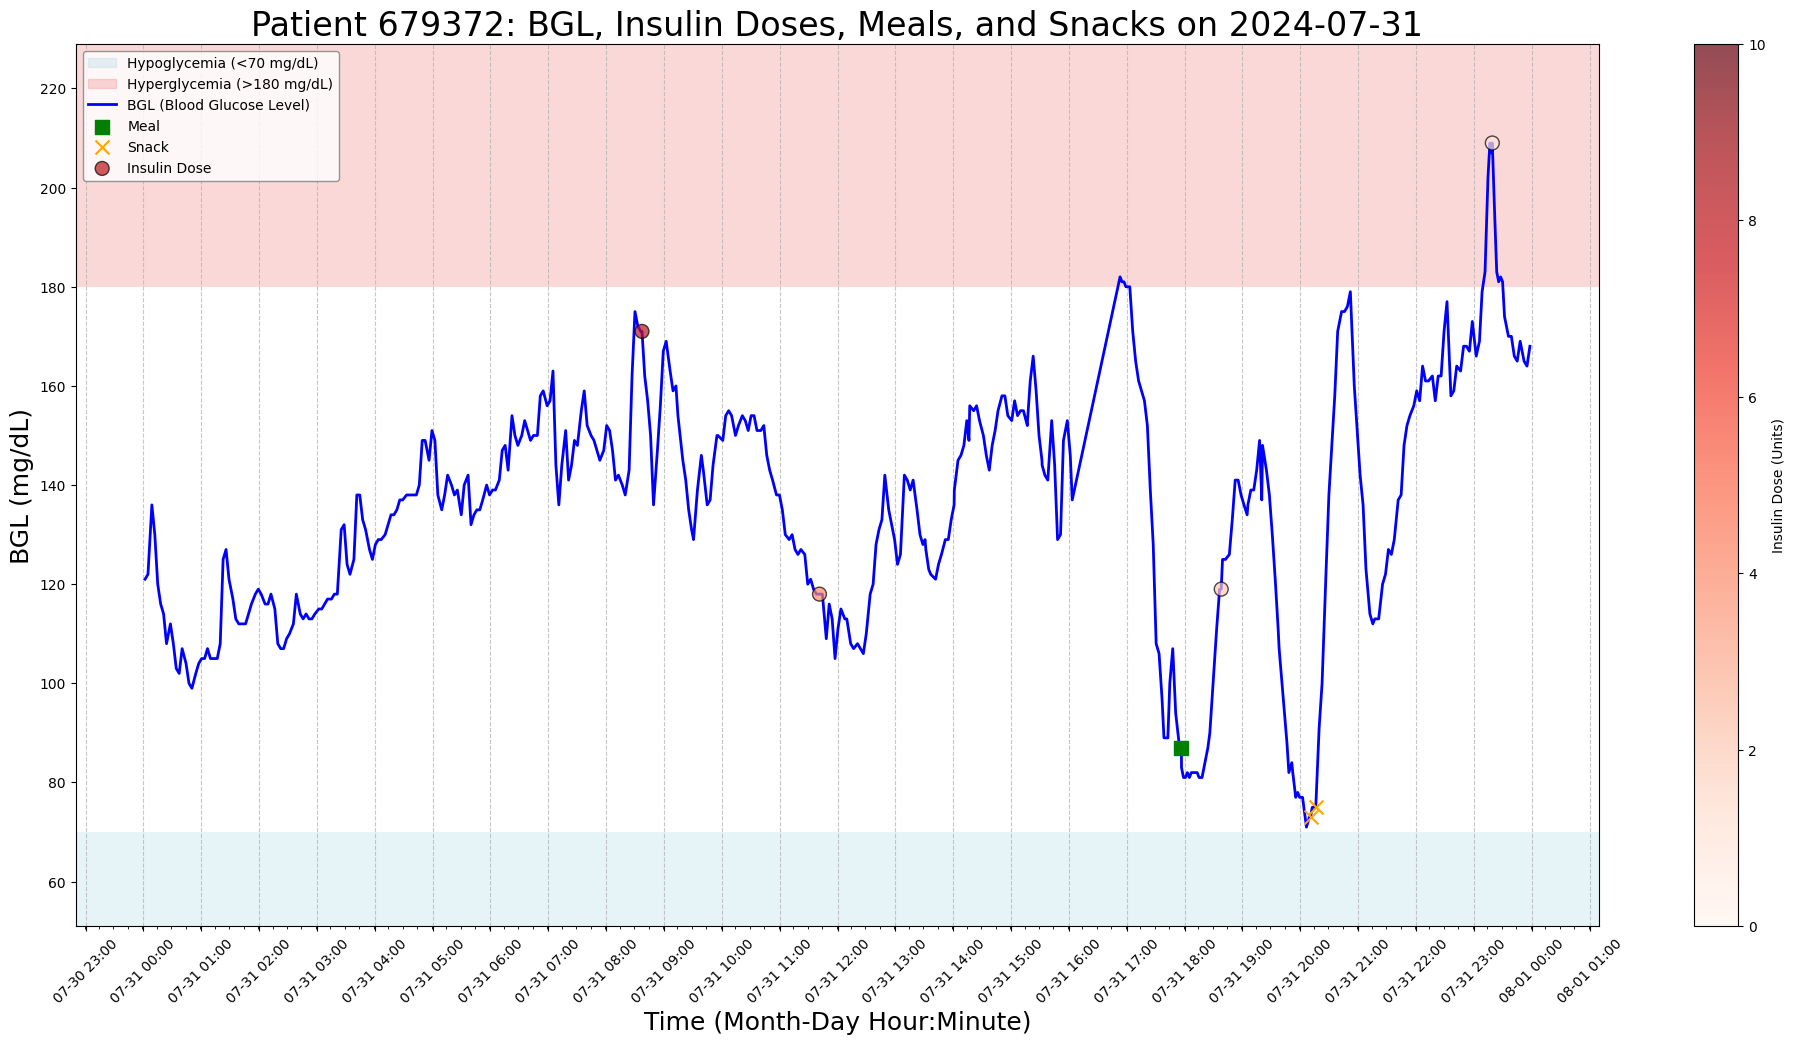

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
import matplotlib.dates as mdates 
from datetime import datetime
import os
import re 


def plot_insulin_bgl_meals_snacks(filename, date=None):
    """
    To plot insulin doses (as red dots with dynamic shading to indicate dosage), glucose levels (as a line),
    and meals/snacks (as scatter points) for a specified day, with
    background colors showing hyperglycemia and hypoglycemia.

    Displays the blood glucose relative to time visualization for the specified day.

    Params:
        filename (str): Path to the CSV file.
        date (str, optional): Specific date to plot in 'YYYY-MM-DD' format.
        If not given, the function plots data for the most recent day.

    Returns:
        None. 
    """
    # Load the CSV file with error handling
    df = pd.read_csv(filename)

    # Clean and convert the date column to datetime
    df['date'] = df['date'].astype(str) 
    df['date'] = df['date'].str.replace(r'\.\d{6}', '', regex=True)
    df['date'] = df['date'].str.replace(r'[-+]\d{2}:\d{2}', '', regex=True)

    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='raise')


    # Determine the date to plot
    if date is None:
        # Select the most recent date in the dataset
        latest_datetime = df['date'].max()
        plot_date = latest_datetime.date()

    else:
        try:
            # Parse the provided date string
            plot_date = datetime.strptime(date, '%Y-%m-%d').date()
        except ValueError:
            print("Error: The provided date format is incorrect. Please use 'YYYY-MM-DD'.")
            return

    # Filter the dataset for the date
    df_filtered = df[df['date'].dt.date == plot_date]

    if df_filtered.empty:
        print(f"Warning: No data available for the date {plot_date}. Please choose a different date.")
        return

    # Sort the filtered data by date
    df_filtered = df_filtered.sort_values('date')

    # Extract Patient Number from Filename
    basename = os.path.basename(filename)  
    match = re.search(r'(\d+)', basename)
    if match:
        patient_number = match.group(1)
    else:
        patient_number = 'Unknown'

    # Separate insulin doses, BGL readings, and meals/snacks
    insulin_df = df_filtered[
        df_filtered['msg_type'].isin(['DOSE_INSULIN', 'DOSE_BASAL_INSULIN']) & 
        df_filtered['dose_units'].notna()
    ]
    bgl_df = df_filtered[~df_filtered['bgl'].isna()].copy()  
    meal_df = df_filtered[df_filtered['msg_type'] == 'ANNOUNCE_MEAL']
    snack_df = df_filtered[df_filtered['msg_type'] == 'INTERVENTION_SNACK']

    # Interpolate BGL to estimate values at insulin dose times
    if not bgl_df.empty and not insulin_df.empty:
        # Set 'date' as index for interpolation
        bgl_df.set_index('date', inplace=True)
        insulin_times = insulin_df['date']

        # Perform linear interpolation
        interpolated_bgl = bgl_df['bgl'].reindex(bgl_df.index.union(insulin_times)).interpolate(method='time').reindex(insulin_times).values
        insulin_df = insulin_df.copy() 
        insulin_df['bgl_at_dose'] = interpolated_bgl
    else:
        insulin_df['bgl_at_dose'] = np.nan  

    # Create the plot 
    fig, ax = plt.subplots(figsize=(20, 10))  

    # Plot BGL readings as a blue line
    ax.plot(bgl_df.index, bgl_df['bgl'], label='BGL (Blood Glucose Level)', color='blue', lw=2, zorder=2)

    # Plot meals as green squares
    ax.scatter(
        meal_df['date'], 
        meal_df['bgl'], 
        label='Meal', 
        color='green', 
        s=100, 
        marker='s',  
        zorder=4
    )

    # Plot snacks as orange crosses
    ax.scatter(
        snack_df['date'], 
        snack_df['bgl'], 
        label='Snack', 
        color='orange', 
        s=100, 
        marker='x',
        zorder=4
    )

    # Set up color normalization for insulin doses (0 to 10)
    norm = Normalize(vmin=0, vmax=10)

    # Plot insulin doses as red circles with black edges
    scatter_insulin = ax.scatter(
        insulin_df['date'], 
        insulin_df['bgl_at_dose'], 
        label='Insulin Dose', 
        c=insulin_df['dose_units'], 
        cmap='Reds', 
        norm=norm,
        s=100, 
        marker='o',
        alpha=0.7,
        edgecolors='k',  
        zorder=3
    )
    cbar = plt.colorbar(scatter_insulin, ax=ax, label='Insulin Dose (Units)')

    # Set y-axis limits 
    min_bgl = bgl_df['bgl'].min()
    max_bgl = bgl_df['bgl'].max()

    padding = 20
    ax.set_ylim(min_bgl - padding, max(max_bgl + padding, 200))  

    # Add background color for hypoglycemia (BGL < 70)
    ax.axhspan(ymin=0, ymax=70, facecolor='lightblue', alpha=0.3, zorder=1)

    # Add background color for hyperglycemia (BGL > 180)
    ax.axhspan(ymin=180, ymax=ax.get_ylim()[1], facecolor='lightcoral', alpha=0.3, zorder=1)

    # Format the x-axis to show day and hour
    date_format = mdates.DateFormatter('%m-%d %H:%M')  # e.g., 09-20 14:30
    ax.xaxis.set_major_formatter(date_format)

    # Define the major locator as every hour
    major_locator = mdates.HourLocator(interval=1)
    ax.xaxis.set_major_locator(major_locator)

    # Define minor locator as every 15 minutes
    minor_locator = mdates.MinuteLocator(interval=15)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(which='major', axis='x', linestyle='--', alpha=0.7)

    # Add labels and titles
    ax.set_title(f'Patient {patient_number}: BGL, Insulin Doses, Meals, and Snacks on {plot_date}', fontsize=24)
    ax.set_xlabel('Time (Month-Day Hour:Minute)', fontsize=18)
    ax.set_ylabel('BGL (mg/dL)', fontsize=18)

    # Combine legends from all plot elements
    handles, labels = ax.get_legend_handles_labels()
    hypoglycemia_patch = Patch(facecolor='lightblue', edgecolor='lightblue', alpha=0.3, label='Hypoglycemia (<70 mg/dL)')
    hyperglycemia_patch = Patch(facecolor='lightcoral', edgecolor='lightcoral', alpha=0.3, label='Hyperglycemia (>180 mg/dL)')

    handles = [hypoglycemia_patch, hyperglycemia_patch] + handles
    labels = ['Hypoglycemia (<70 mg/dL)', 'Hyperglycemia (>180 mg/dL)'] + labels
    ax.legend(handles, labels, loc='upper left', fontsize='medium',
              facecolor='white', framealpha=0.8, edgecolor='gray')

    fig.tight_layout()
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

plot_insulin_bgl_meals_snacks(r'..\data\gluroo_500030.csv')
plot_insulin_bgl_meals_snacks(r'..\data\gluroo_679372.csv')

**Conclusions from Visualization 2:**

The visualization succesfully shows the significant events and information relating to the patient's glucose levels throughout a specific day. 
- When the patient eats their Meal (Through a Green Square Symbol)
- When the patient eats their Snack (Through a Yellow X Symbol)
- When the patient injects their Insuline (Through a Dynamically Shaded Red Circle [The darker the red the higher the dosage])
- When the user enters the range of hypoglycemia and hyperglycemia. (Through blue shaded area for hypoglycemia and light red shaded area for hyperglycemia) 

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. As I'm looking at the csv files I'm noticing that the meals/snacks do not consider the amount of other nutrients that are taken with/preceiding the carbohydrates. I've read in several medical studies that indicated that ingestion of protein, fats, and fibre before the  carbs would reduce the blood glucose spike significantly as it delays the absorption of carbs. Do you guys have any plans to implement the entire meal while creating the diabetes management solution? 

Source:
https://www.joslin.org/patient-care/diabetes-education/diabetes-learning-center/carbs-protein-and-fats-their-effect#:~:text=Fiber%2C%20protein%20and%20fats%20help,in%20glucose%20levels%20after%20eating.

2. I've also saw that the team currently sets the GI index of foods at 1 for snacks and 0.5 for meals. I see that you guys are trying to implement GI index to the diabetes management system which sounds great but I was curious to see how you would isolate the GI index for each meal/snacks the individual consumes if it contains more than one identified ingredient. For instance, if a patient eats a Snickers bar how would we determine it's GI index? Would we use some sort of generative AI to estimate or would we have some sort of algorithm that can accurately estimate it? 

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`